In [20]:
# 1. Need to Get the Airport Location NY_Airport_Data [Done]
import csv
import pandas as pd
from lat_lon_parser import parse
import folium as fd
from IPython.display import HTML, display

airport_df = pd.read_csv(r'Aircraft_Landing_Facilities.csv')
airport_df = airport_df[['ref_point_lat','ref_point_lon','objectid','fac_type','loc_id','region_code','state_name','county','fac_name']]
airport_df = airport_df[airport_df.state_name=='WASHINGTON']
airport_df = airport_df[airport_df.fac_type=='AIRPORT']

airport_df_temp = airport_df.reset_index(drop=True)


def calculate_lat(row):
    val = parse(row['ref_point_lat'])
    return val
def calculate_lon(row):
    val = parse(row['ref_point_lon'])
    return val

airport_df['lat'] = (airport_df.apply(calculate_lat, axis=1)).round(2)
airport_df['lon'] = (airport_df.apply(calculate_lon, axis=1)).round(3)
airport_df = airport_df.reset_index(drop=True)


/Users/meghasinghrajpoot/opt/anaconda3/envs/dataBaseFinal/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (51,52,53) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [21]:
import xarray as xr
import pandas as pd
import numpy as np
import os


for i in range(1,396):

    netcdf_file_name = './data/windData/' + str(i) + '.nc4'
    csv_file_out = './data/windCSV/' + str(i) + '.csv'

    ds = xr.open_dataset(netcdf_file_name)
    df = ds.to_dataframe()
    print(df.describe())
    df.to_csv(csv_file_out)

    windspeed_df = pd.read_csv(csv_file_out)
    windspeed_df = pd.DataFrame(windspeed_df)

    windspeed_df = windspeed_df[['lat','lon','U50M','V50M','time']]
    windspeed_df['lat'] = windspeed_df['lat'].round(2)
    windspeed_df['lon'] = windspeed_df['lon'].round(2)
    windspeed_df['date'] = pd.to_datetime(windspeed_df['time']).dt.date

    csv_file_out_processed = './data/windCSV/' + str(i) + "_final.csv"
    windspeed_df.to_csv(csv_file_out_processed)
    os.remove(csv_file_out)


    # Compute the wind speed for the NewYork State on daily basis.....

    windspeed_df = pd.read_csv(csv_file_out_processed)
    windspeed_df = pd.DataFrame(windspeed_df)

    lon = windspeed_df['lon']
    lat = windspeed_df['lat']
    date = windspeed_df['date']

    # 2-meter eastward wind m/s
    U50M = windspeed_df['U50M']
    # 2-meter northward wind m/s
    V50M = windspeed_df['V50M']

    # Replace _FillValues with NaNs:df.replace(r'^\s*$', np.nan, regex=True)
    U2M_nans = U50M[:].replace(r'^\s*$', np.nan, regex=True)
    V2M_nans = V50M[:].replace(r'^\s*$', np.nan, regex=True)

    # Calculate wind speed:
    ws = np.sqrt(U2M_nans**2+V2M_nans**2)
    list_s = [lat, lon, date]

    new_df = pd.concat(list_s, axis=1)
    new_df['avg_windspeed'] = ws
    print(new_df.columns)
    new_df = pd.DataFrame(new_df.groupby(['lat','lon']).mean()).reset_index()
    new_df['date'] = date
    new_df.to_csv(csv_file_out_processed)



/Users/meghasinghrajpoot/opt/anaconda3/envs/dataBaseFinal/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
/Users/meghasinghrajpoot/opt/anaconda3/envs/dataBaseFinal/lib/python3.9/site-packages/xarray/backends/plugins.py:65: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


              V50M         U50M
count  3240.000000  3240.000000
mean      1.689961     1.285675
std       2.260250     2.770550
min      -3.441572    -5.846003
25%       0.109876    -0.531588
50%       1.829845     1.264850
75%       3.066491     2.954175
max      11.884532     9.757247
Index(['lat', 'lon', 'date', 'avg_windspeed'], dtype='object')
              V50M         U50M
count  3240.000000  3240.000000
mean      2.817701    -1.401734
std       2.574836     3.072235
min      -4.619536    -8.510232
25%       1.254323    -3.476224
50%       2.626736    -2.017866
75%       4.134955     0.194230
max      12.607832    14.673664
Index(['lat', 'lon', 'date', 'avg_windspeed'], dtype='object')
              V50M         U50M
count  3240.000000  3240.000000
mean      2.573384     4.114732
std       1.672569     2.537186
min      -4.570351    -4.647210
25%       1.426266     2.718043
50%       2.678069     4.080636
75%       3.626297     5.747878
max       8.493994    14.631956
Index(['la

In [22]:
def generate_blocks(csv_file_out):
    ws_df = pd.read_csv(csv_file_out)
    ws_df = pd.DataFrame(ws_df)

    _blocks = {
        'lower_left_lat': [],
        'lower_left_lon': [],
        'upper_right_lat': [],
        'upper_right_lon': [],
        'avg_speed': [],
        'date': [],

    }
    # retrieve lat lon list
    lat_list = sorted(set(ws_df['lat'].tolist()))
    lon_list = sorted(set(ws_df['lon'].tolist()))
    date_list = (set(ws_df['date'].tolist()))
    # for loop to generate all blocks
    # todo change 'avg windspeed' to wind speed
    speed = 0
    for x in range(len(lat_list) - 1):
        for y in range(len(lon_list) - 1):
            speed += ws_df[
                (ws_df['lat'] == lat_list[x]) &
                (ws_df['lon'] == lon_list[y])]['avg_windspeed'].tolist()[0]
            speed += ws_df[
                (ws_df['lat'] == lat_list[x + 1]) &
                (ws_df['lon'] == lon_list[y])]['avg_windspeed'].tolist()[0]
            speed += ws_df[
                (ws_df['lat'] == lat_list[x]) &
                (ws_df['lon'] == lon_list[y + 1])]['avg_windspeed'].tolist()[0]
            speed += ws_df[
                (ws_df['lat'] == lat_list[x + 1]) &
                (ws_df['lon'] == lon_list[y + 1])]['avg_windspeed'].tolist()[0]

            speed = speed / 4
            _blocks['lower_left_lat'].append(lat_list[x])
            _blocks['upper_right_lat'].append(lat_list[x + 1])
            _blocks['lower_left_lon'].append(lon_list[y])
            _blocks['upper_right_lon'].append(lon_list[y + 1])
            _blocks['avg_speed'].append(speed)
            _blocks['date'].append(ws_df.loc[x,'date'])
            speed = 0
        
        
    blocks = pd.DataFrame(_blocks)
    blocks.to_csv(csv_file_out)


for i in range(1,395):
    csv_file_out = './data/windCSV/' + str(i) + '_final.csv'
    blocks = generate_blocks(csv_file_out)
    

KeyboardInterrupt: 

In [ ]:
airport_df = airport_df.sort_values('lat')

locations = airport_df[['lat','lon']]
wind_locations = new_df[['lat','lon']]
locations_list = locations.values.tolist()
wind_list = wind_locations.values.tolist()

map = fd.Map(location=[43, -75], zoom_start=12)

for point in range(0, len(locations_list)):
    # print(locations_list[point], point)
    fd.Marker(locations_list[point], popup=airport_df['fac_name'][point]).add_to(map)


for point in range(0, len(wind_list)):
    # print(wind_list[point], point)
    fd.Marker(wind_list[point], popup=new_df['avg_windspeed'][point], icon=fd.Icon(color='red')).add_to(map)

map.save('map.html')



In [ ]:
# Merge the data sets [Issues encountered]
def calculate_airport_avg_windspeed(airport_df, blocks):

    for row_id, row in airport_df.iterrows():
        lat_val = row.lat
        lon_val = row.lon
        filter1_a = lat_val >= blocks['lower_left_lat']
        filter1_b = lat_val <= blocks['upper_right_lat']
        filter2_a = lon_val >= blocks['lower_left_lon']
        filter2_b = lon_val <= blocks['upper_right_lon']
        calc_time = blocks[(filter1_a) & (filter1_b) & (filter2_a) & (filter2_b)].date.tolist()[0]
        calc_speed_temp = round(blocks[(filter1_a) & (filter1_b) & (filter2_a) & (filter2_b)].avg_speed.tolist()[0], 3)
        (airport_df.at[row_id, calc_time]) = calc_speed_temp
    
    return airport_df



airport_df_temp = airport_df.copy()
for i in range(1,395):
    csv_file_out = './data/windCSV/' + str(i) + '_final.csv'
    blocks_ = pd.read_csv(csv_file_out)
    blocks_ = pd.DataFrame(blocks_)
    airport_df_temp = calculate_airport_avg_windspeed(airport_df_temp, blocks_)

final_dataset_with_speed_and_airport = airport_df_temp

final_dataset_with_speed_and_airport = final_dataset_with_speed_and_airport.reset_index(drop=True)

print(final_dataset_with_speed_and_airport)



      ref_point_lat    ref_point_lon  objectid fac_type loc_id region_code  \
0    47-05-05.3300N  123-46-25.6000W     18379  AIRPORT   94WA         ANM   
1    48-42-34.4070N  122-10-39.5660W     18381  AIRPORT   WA12         ANM   
2    48-18-50.2000N  117-50-25.1000W     18382  AIRPORT   WA57         ANM   
3    45-54-00.0000N  119-54-20.0000W     18383  AIRPORT   WA00         ANM   
4    45-55-59.4020N  122-25-04.3530W     18384  AIRPORT   WA79         ANM   
..              ...              ...       ...      ...    ...         ...   
351  46-46-50.4600N  120-26-39.2300W     18913  AIRPORT   WN45         ANM   
352  46-50-49.3640N  122-31-19.4290W     18914  AIRPORT   49WA         ANM   
353  46-55-29.9450N  122-33-10.9400W     18915  AIRPORT   06WN         ANM   
354  46-23-37.4650N  120-13-18.1910W     18916  AIRPORT   68WA         ANM   
355  48-00-07.2000N  117-15-48.0000W     18917  AIRPORT   WN04         ANM   

     state_name        county                       fac_name   

In [ ]:
import datetime as dt

print(len(final_dataset_with_speed_and_airport.columns))
temp = final_dataset_with_speed_and_airport.copy()
lenght_val = len(temp.columns)
temp['Jan'] = 0; temp['Feb'] = 0; temp['Mar'] = 0;temp['Apr'] = 0;temp['May'] = 0;temp['June'] = 0;temp['July'] = 0;temp['Aug'] = 0;temp['Sep'] = 0;temp['Oct'] = 0;temp['Nov'] = 0;temp['Dec'] = 0
for cols in temp.columns[11:lenght_val]:
    val = pd.to_numeric(cols.split('-')[1]) 
    if val == 1:
        temp['Jan'] += temp[cols]
    elif val == 2:
        temp['Feb'] += temp[cols]
    elif val == 3:
        temp['Mar'] += temp[cols]
    elif val == 4:
        temp['Apr'] += temp[cols]
    elif val == 5:
        temp['May'] += temp[cols]
    elif val == 6:
        temp['June'] += temp[cols]
    elif val == 7:
        temp['July'] += temp[cols]
    elif val == 8:
        temp['Aug'] += temp[cols]
    elif val == 9:
        temp['Sep'] += temp[cols]
    elif val == 10:
        temp['Oct'] += temp[cols]
    elif val == 11:
        temp['Nov'] += temp[cols]
    elif val == 12:
        temp['Dec'] += temp[cols]

temp = temp.drop(temp.columns[11:lenght_val], axis = 1)
final_df_models = temp.copy()


403


In [ ]:
temp.to_csv('./data/windData/'+ 'Final_DataSet.csv')

Index(['ref_point_lat', 'ref_point_lon', 'objectid', 'fac_type', 'loc_id',
       'region_code', 'state_name', 'county', 'fac_name', 'lat', 'lon', 'Jan',
       'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov',
       'Dec'],
      dtype='object')

Clustering Alogs: OPTICS

OPTICS clustering (where OPTICS is short for Ordering Points To Identify the Clustering Structure) is a modified version of DBSCAN described above.

We introduce a new algorithm for the purpose of cluster analysis which does not produce a clustering of a data set explicitly; but instead creates an augmented ordering of the database representing its density-based clustering structure. This cluster-ordering contains information which is equivalent to the density-based clusterings corresponding to a broad range of parameter settings.

— OPTICS: ordering points to identify the clustering structure, 1999.

The technique is described in the paper:

OPTICS: ordering points to identify the clustering structure, 1999.
It is implemented via the OPTICS class and the main configuration to tune is the “eps” and “min_samples” hyperparameters.

In [ ]:

import sklearn
print(sklearn.__version__)

1.0.1


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.preprocessing import normalize, StandardScaler

In [35]:
#Read final processed data frame.
final_df_models = pd.read_csv('./data/windData/'+ 'Final_DataSet.csv')
final_df_models = final_df_models.drop(columns=['Unnamed: 0'])
final_df_models.head()

,ref_point_lat,ref_point_lon,objectid,fac_type,loc_id,region_code,state_name,county,fac_name,lat,...,Mar,Apr,May,June,July,Aug,Sep,Oct,Nov,Dec
0,47-05-05.3300N,123-46-25.6000W,18379,AIRPORT,94WA,ANM,WASHINGTON,GRAYS HARBOR,WISHKAH RIVER RANCH,47.08,...,161.042,111.243,264.025,123.266,114.580,126.218,117.590,134.876,172.823,190.318
1,48-42-34.4070N,122-10-39.5660W,18381,AIRPORT,WA12,ANM,WASHINGTON,WHATCOM,ACME FIELD,48.71,...,103.338,85.071,163.432,75.195,67.496,67.041,77.909,97.279,125.490,127.480
2,48-18-50.2000N,117-50-25.1000W,18382,AIRPORT,WA57,ANM,WASHINGTON,STEVENS,BLUECREEK,48.31,...,111.001,119.303,223.239,99.900,106.058,107.340,97.483,110.604,106.170,92.814
3,45-54-00.0000N,119-54-20.0000W,18383,AIRPORT,WA00,ANM,WASHINGTON,KLICKITAT,MERCER RANCH,45.90,...,180.823,182.768,347.301,181.641,166.941,171.531,159.781,202.419,210.485,187.871
4,45-55-59.4020N,122-25-04.3530W,18384,AIRPORT,WA79,ANM,WASHINGTON,CLARK,WALTER SUTTON'S PRIVATE STRIP,45.93,...,110.827,108.939,220.486,105.590,96.342,102.130,108.225,112.080,126.933,151.481


In [88]:
airport_dataframe = final_df_models
county_list = final_df_models['county'].unique().tolist()


airport_dataframe['Category'] = airport_dataframe.county.astype("category").cat.codes

airport_dataframe.head()
airport_dataframe.to_csv('./data/windData/'+ 'Category_DataSet.csv')

In [36]:
# Handling the missing values if any

airport_dataframe = final_df_models
county_list = final_df_models['county'].unique().tolist()

airport_dataframe['Category'] = airport_dataframe.county.astype("category").cat.codes
airport_dataframe_temp = airport_dataframe[['Jan','Feb','Mar','Apr','May','June','July','Aug','Sep','Oct','Nov','Dec','Category']].copy()
temp.to_csv('./data/windData/'+ 'Final_DataSet.csv')

scaler = StandardScaler()
airport_dataframe_scaled = scaler.fit_transform(airport_dataframe_temp)
airport_normalized = normalize(airport_dataframe_scaled)
airport_normalized = pd.DataFrame(airport_normalized)
airport_normalized.columns = airport_dataframe_temp.columns
print(airport_normalized.head())


# Building the OPTICS Clustering model
optics_model = OPTICS(min_samples = 50, xi = 0.05, min_cluster_size = 0.05)
  
# Training the model
optics_model.fit_predict(airport_normalized)

labels_050 = cluster_optics_dbscan(
    reachability=optics_model.reachability_,
    core_distances=optics_model.core_distances_,
    ordering=optics_model.ordering_,
    eps=0.5,
)
labels_200 = cluster_optics_dbscan(
    reachability=optics_model.reachability_,
    core_distances=optics_model.core_distances_,
    ordering=optics_model.ordering_,
    eps=2,
)

# Storing the cluster labels of each point
reachability = optics_model.reachability_[optics_model.ordering_]
labels = optics_model.labels_[optics_model.ordering_]
space = np.arange(len(airport_normalized))

print(labels)
print(reachability)

    

        Jan       Feb       Mar       Apr       May      June      July  \
0  0.437220  0.225593  0.380391 -0.121175  0.114366  0.085318  0.058329   
1 -0.105846 -0.272151 -0.240734 -0.262125 -0.328429 -0.328196 -0.331843   
2 -0.385670 -0.293933 -0.226208 -0.041243 -0.111153 -0.167996 -0.034293   
3  0.264209  0.349112  0.259493  0.231244  0.245262  0.310906  0.266482   
4 -0.210663 -0.178591 -0.348396 -0.202325 -0.192054 -0.164630 -0.206071   

        Aug       Sep       Oct       Nov       Dec  Category  
0  0.164888  0.107284  0.062071  0.350100  0.598936 -0.225741  
1 -0.368271 -0.326686 -0.268635 -0.157105 -0.127485  0.326992  
2 -0.049621 -0.167451 -0.206409 -0.421664 -0.564732  0.316871  
3  0.285124  0.294423  0.353650  0.333065  0.235214 -0.019204  
4 -0.161003 -0.038015 -0.290602 -0.288974  0.166186 -0.657280  
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0 

# DBSCAN at 0.5


Text(0.5, 1.0, 'Clustering at 2.0 epsilon cut\nDBSCAN')

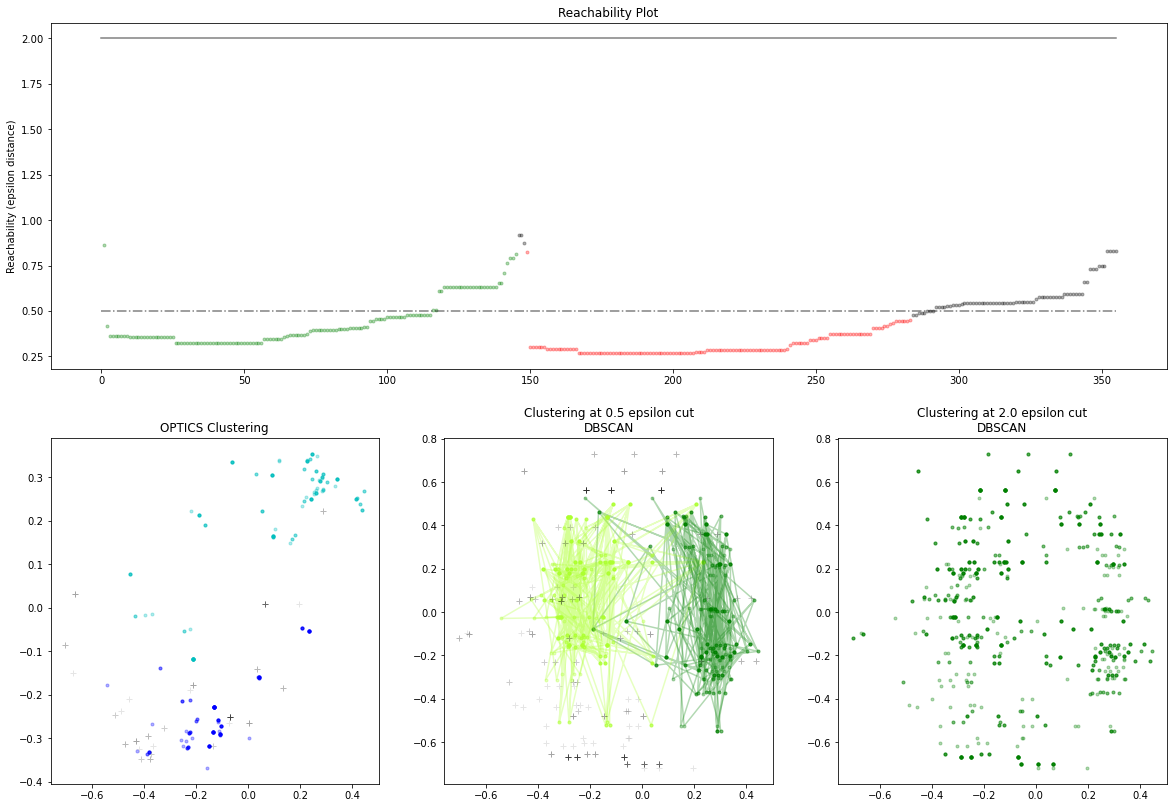

In [ ]:
# Defining the framework of the visualization
plt.figure(figsize =(20, 14))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])


# Reachability plot
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot")


# Plotting the OPTICS Clustering
colors = ['c.', 'b.', 'r.', 'y.', 'g.']
for Class, colour in zip(range(0, 5), colors):
    Xk = airport_normalized[optics_model.labels_ == Class]
    ax2.plot(Xk.iloc[:, 0], Xk.iloc[:, 1], colour, alpha = 0.3)
      
ax2.plot(airport_normalized.iloc[optics_model.labels_ == -1, 0],
        airport_normalized.iloc[optics_model.labels_ == -1, 1],
       'k+', alpha = 0.1)
ax2.set_title('OPTICS Clustering')


# DBSCAN at 0.5
colors = ["g", "greenyellow", "olive", "r", "b", "c"]
print('# DBSCAN at 0.5')


for i in range(0,3):
    for klass, color in zip(range(0, 6), colors):
        Xk = airport_normalized[labels_050 == klass]
        ax3.plot(Xk[airport_normalized.columns[i]], Xk['Category'], color, alpha=0.3, marker=".")


# DBSCAN at 2.
colors = ["g.", "m.", "y.", "c."]
for i in range(0,3):
    for klass, color in zip(range(0, 4), colors):
        Xk = airport_normalized[labels_200 == klass]
        ax4.plot(Xk[airport_normalized.columns[i]], Xk['Category'], color, alpha=0.3)


for i in range(0,3):
    ax3.plot(airport_normalized.loc[labels_050 == -1, airport_normalized.columns[i]], airport_normalized.loc[labels_050 == -1, 'Category'], "k+", alpha=0.1)       
    ax4.plot(airport_normalized.loc[labels_200 == -1, airport_normalized.columns[i]], airport_normalized.loc[labels_200 == -1, 'Category'], "k+", alpha=0.1)

ax3.set_title("Clustering at 0.5 epsilon cut\nDBSCAN")
ax4.set_title("Clustering at 2.0 epsilon cut\nDBSCAN")

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a
Kmeans algorithm is an iterative algorithm that tries to partition the dataset into Kpre-defined distinct non-overlapping subgroups (clusters) where each data point belongs to only one group. It tries to make the intra-cluster data points as similar as possible while also keeping the clusters as different (far) as possible. It assigns data points to a cluster such that the sum of the squared distance between the data points and the cluster’s centroid (arithmetic mean of all the data points that belong to that cluster) is at the minimum. The less variation we have within clusters, the more homogeneous (similar) the data points are within the same cluster.

In [ ]:
final_df_models2 = pd.read_csv('./data/windData/'+ 'Final_DataSet.csv')
final_df_models2 = final_df_models2.drop(columns=['Unnamed: 0'])
final_df_models2.head()

,ref_point_lat,ref_point_lon,objectid,fac_type,loc_id,region_code,state_name,county,fac_name,lat,...,Mar,Apr,May,June,July,Aug,Sep,Oct,Nov,Dec
0,47-05-05.3300N,123-46-25.6000W,18379,AIRPORT,94WA,ANM,WASHINGTON,GRAYS HARBOR,WISHKAH RIVER RANCH,47.08,...,161.042,111.243,264.025,123.266,114.580,126.218,117.590,134.876,172.823,190.318
1,48-42-34.4070N,122-10-39.5660W,18381,AIRPORT,WA12,ANM,WASHINGTON,WHATCOM,ACME FIELD,48.71,...,103.338,85.071,163.432,75.195,67.496,67.041,77.909,97.279,125.490,127.480
2,48-18-50.2000N,117-50-25.1000W,18382,AIRPORT,WA57,ANM,WASHINGTON,STEVENS,BLUECREEK,48.31,...,111.001,119.303,223.239,99.900,106.058,107.340,97.483,110.604,106.170,92.814
3,45-54-00.0000N,119-54-20.0000W,18383,AIRPORT,WA00,ANM,WASHINGTON,KLICKITAT,MERCER RANCH,45.90,...,180.823,182.768,347.301,181.641,166.941,171.531,159.781,202.419,210.485,187.871
4,45-55-59.4020N,122-25-04.3530W,18384,AIRPORT,WA79,ANM,WASHINGTON,CLARK,WALTER SUTTON'S PRIVATE STRIP,45.93,...,110.827,108.939,220.486,105.590,96.342,102.130,108.225,112.080,126.933,151.481


In [ ]:
kmeans_model_dataframe = final_df_models2.copy()

kmeans_model_dataframe['Category'] = kmeans_model_dataframe.county.astype("category").cat.codes

kmeans_model_dataframe = kmeans_model_dataframe[['Jan','Feb','Mar','Apr','May','June','July','Aug','Sep','Oct','Nov','Dec','Category']].copy()
kmeans_model_dataframe

scaler = StandardScaler()
kmeans_model_dataframe_norm = scaler.fit_transform(kmeans_model_dataframe)
kmeans_model_dataframe_norm = normalize(kmeans_model_dataframe_norm)
kmeans_model_dataframe_norm = pd.DataFrame(kmeans_model_dataframe_norm)
kmeans_model_dataframe_norm.columns = kmeans_model_dataframe_norm.columns
print(kmeans_model_dataframe_norm.head())


         0         1         2         3         4         5         6   \
0  0.437220  0.225593  0.380391 -0.121175  0.114366  0.085318  0.058329   
1 -0.105846 -0.272151 -0.240734 -0.262125 -0.328429 -0.328196 -0.331843   
2 -0.385670 -0.293933 -0.226208 -0.041243 -0.111153 -0.167996 -0.034293   
3  0.264209  0.349112  0.259493  0.231244  0.245262  0.310906  0.266482   
4 -0.210663 -0.178591 -0.348396 -0.202325 -0.192054 -0.164630 -0.206071   

         7         8         9         10        11        12  
0  0.164888  0.107284  0.062071  0.350100  0.598936 -0.225741  
1 -0.368271 -0.326686 -0.268635 -0.157105 -0.127485  0.326992  
2 -0.049621 -0.167451 -0.206409 -0.421664 -0.564732  0.316871  
3  0.285124  0.294423  0.353650  0.333065  0.235214 -0.019204  
4 -0.161003 -0.038015 -0.290602 -0.288974  0.166186 -0.657280  


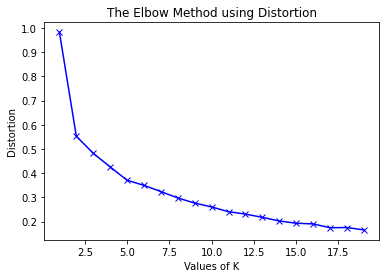

In [ ]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 20)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(kmeans_model_dataframe_norm)
    distortions.append(sum(np.min(cdist(kmeans_model_dataframe_norm, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / kmeans_model_dataframe_norm.shape[0])
    inertias.append(kmeanModel.inertia_)
    mapping1[k] = sum(np.min(cdist(kmeans_model_dataframe_norm, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / kmeans_model_dataframe_norm.shape[0]
    mapping2[k] = kmeanModel.inertia_



plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()


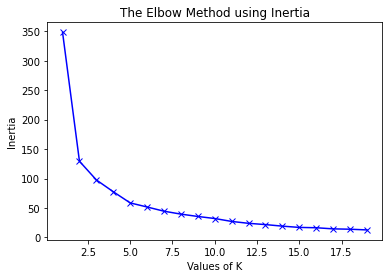

In [ ]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [ ]:
#Initialize the class object
kmeans = KMeans(n_clusters= 5)
 
#predict the labels of clusters.
label = kmeans.fit_predict(kmeans_model_dataframe)
 
print((label))

[2 3 4 1 0 0 3 3 2 3 3 2 3 3 3 1 0 0 0 0 3 3 3 1 3 3 3 3 3 4 0 0 3 3 1 3 3
 0 4 0 0 0 3 3 2 3 3 3 2 2 1 2 2 4 2 0 0 2 2 1 1 1 4 4 4 3 1 3 2 0 2 3 3 3
 3 2 2 3 3 2 2 2 2 3 3 0 3 3 3 3 3 2 2 2 2 2 2 0 0 0 3 3 3 2 3 3 3 3 3 3 3
 2 1 3 3 3 0 3 4 0 2 2 2 2 2 3 1 3 3 3 2 1 1 1 1 1 1 4 1 1 1 1 3 0 3 1 3 4
 3 2 3 0 0 1 3 3 4 4 1 3 3 3 3 3 3 2 2 2 2 4 2 2 2 1 1 1 4 3 3 3 1 1 3 1 2
 2 4 4 2 3 3 0 1 1 2 1 4 3 3 3 3 4 4 3 3 4 4 1 1 0 1 1 1 1 1 1 1 1 3 1 0 0
 0 0 3 3 3 3 3 1 1 3 3 1 2 2 3 3 3 2 3 4 4 1 2 1 1 4 0 3 2 2 2 2 1 3 3 4 0
 2 2 2 0 0 0 3 0 3 3 3 3 3 0 0 3 3 3 1 3 3 2 2 2 2 2 2 2 2 2 1 2 4 3 3 1 4
 0 0 1 3 3 2 3 3 0 3 4 1 4 4 4 0 0 2 4 0 0 0 0 0 3 3 3 1 1 1 1 1 1 0 0 1 1
 1 4 2 2 1 0 0 2 2 2 3 1 3 4 0 2 2 2 2 3 3 1 2]


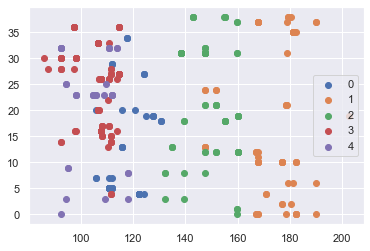

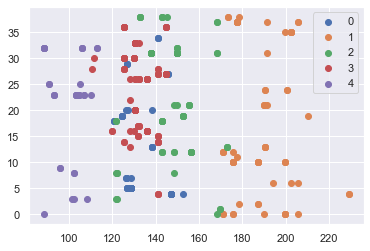

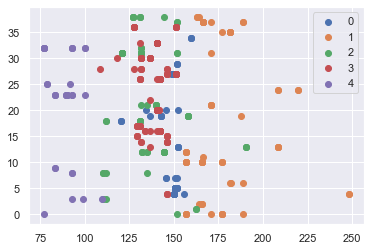

In [91]:

#Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)
 
#plotting the results:

for i in u_labels:
    plt.scatter(kmeans_model_dataframe.loc[label == i , kmeans_model_dataframe.columns[9]] , kmeans_model_dataframe.loc[label == i , 'Category'] , label = i)
    
plt.legend()
plt.show()

for i in u_labels:
    plt.scatter(kmeans_model_dataframe.loc[label == i , kmeans_model_dataframe.columns[10]] , kmeans_model_dataframe.loc[label == i , 'Category'] , label = i)

plt.legend()
plt.show()

for i in u_labels:
    plt.scatter(kmeans_model_dataframe.loc[label == i , kmeans_model_dataframe.columns[11]] , kmeans_model_dataframe.loc[label == i , 'Category'] , label = i)

plt.legend()
plt.show()

Mean Shift Algorithm
Mean Shift is a hierarchical clustering algorithm. In contrast to supervised machine learning algorithms, clustering attempts to group data without having first been train on labeled data. Clustering is used in a wide variety of applications such as search engines, academic rankings and medicine. As opposed to K-Means, when using Mean Shift, you don’t need to know the number of categories (clusters) beforehand. The downside to Mean Shift is that it is computationally expensive — O(n²).

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import MeanShift
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [42]:
meanshift_model_dataframe = final_df_models2.copy()
meanshift_model_dataframe['Category'] = meanshift_model_dataframe.county.astype("category").cat.codes

meanshift_model_dataframe = meanshift_model_dataframe[['Jan','Feb','Mar','Apr','May','June','July','Aug','Sep','Oct','Nov','Dec','Category']].copy()
print(meanshift_model_dataframe)

ms = MeanShift()
ms.fit(meanshift_model_dataframe)
cluster_centers = ms.cluster_centers_
print(cluster_centers)

[[131.05892697 127.63329213 113.6133764   95.62589326 197.8551573
   92.79196067  84.80288202  88.47635955  93.26925281 108.75473034
  132.35574157 139.57914607  20.88764045]
 [157.92913725 180.74994118 159.81946078 170.11037255 317.22684314
  151.51512745 145.88459804 144.79810784 137.86964706 165.04269608
  169.84020588 154.64212745  19.20588235]]


<Figure size 1440x1008 with 0 Axes>

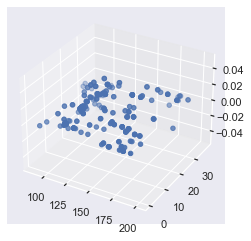

In [66]:
plt.figure(figsize =(20, 14))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(0,12):
    ax.scatter(meanshift_model_dataframe[meanshift_model_dataframe.columns[i]], meanshift_model_dataframe['Category'], marker='o')
    ax.scatter(cluster_centers[:,0], cluster_centers[:,1], marker='x', color='black', s=300, linewidth=5, zorder=10)
plt.show()

In [68]:
scaler = StandardScaler()
meanshift_model_norm = scaler.fit_transform(meanshift_model_dataframe)
meanshift_model_norm = normalize(meanshift_model_norm)
meanshift_model_norm = pd.DataFrame(meanshift_model_norm)
meanshift_model_norm.columns = meanshift_model_norm.columns
print(meanshift_model_norm.head())

         0         1         2         3         4         5         6   \
0  0.437220  0.225593  0.380391 -0.121175  0.114366  0.085318  0.058329   
1 -0.105846 -0.272151 -0.240734 -0.262125 -0.328429 -0.328196 -0.331843   
2 -0.385670 -0.293933 -0.226208 -0.041243 -0.111153 -0.167996 -0.034293   
3  0.264209  0.349112  0.259493  0.231244  0.245262  0.310906  0.266482   
4 -0.210663 -0.178591 -0.348396 -0.202325 -0.192054 -0.164630 -0.206071   

         7         8         9         10        11        12  
0  0.164888  0.107284  0.062071  0.350100  0.598936 -0.225741  
1 -0.368271 -0.326686 -0.268635 -0.157105 -0.127485  0.326992  
2 -0.049621 -0.167451 -0.206409 -0.421664 -0.564732  0.316871  
3  0.285124  0.294423  0.353650  0.333065  0.235214 -0.019204  
4 -0.161003 -0.038015 -0.290602 -0.288974  0.166186 -0.657280  


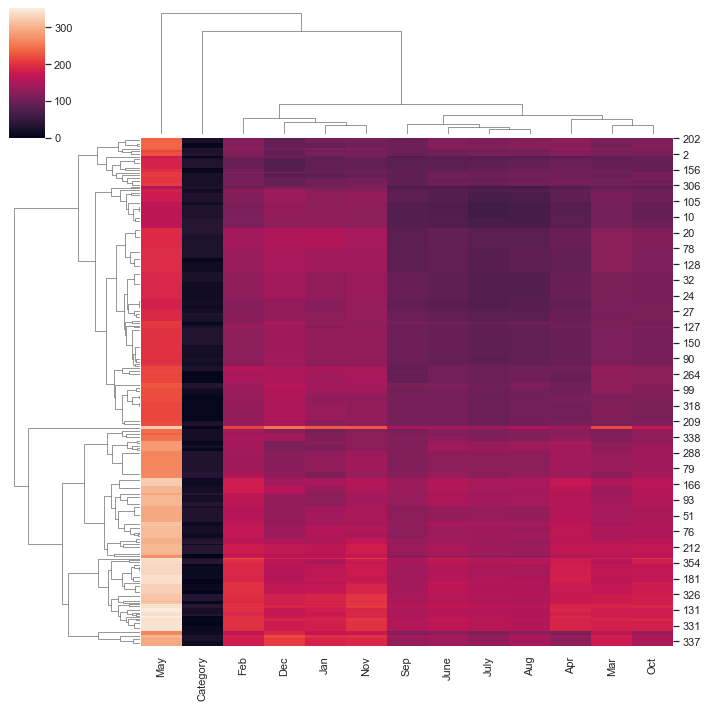

In [74]:
import seaborn as sns; sns.set_theme(color_codes=True)

heatmap_model_dataframe = final_df_models2.copy()
heatmap_model_dataframe['Category'] = heatmap_model_dataframe.county.astype("category").cat.codes
heatmap_model_dataframe.head()

g = sns.clustermap(meanshift_model_dataframe)

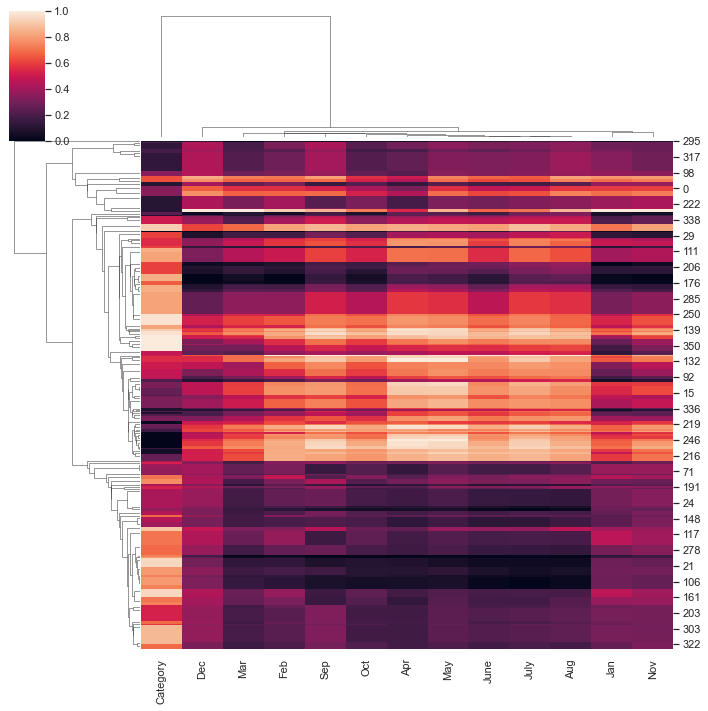

In [75]:
# g = sns.clustermap(meanshift_model_dataframe,
#                    figsize=(10, 10),
#                    row_cluster=True,
#                    dendrogram_ratio=(.1, .2),
#                    cbar_pos=(0, 0.2, .03, .5))#Change the size and layout of the figure.

g = sns.clustermap(meanshift_model_dataframe, metric="correlation",method="single",standard_scale=1)
g = sns.clustermap(meanshift_model_norm, method="single")
g = sns.clustermap(meanshift_model_norm , standard_scale=1)